In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
%env JAX_TRACEBACK_FILTERING=off
import jax
jax.config.update('jax_traceback_filtering', 'off')


env: JAX_TRACEBACK_FILTERING=off


In [4]:
from sprint.icl_sfc_utils import Circuitizer

In [5]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [7]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

fatal: destination path 'data/itv' already exists and is not an empty directory.


737
737
Setting up masks...
Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/3 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

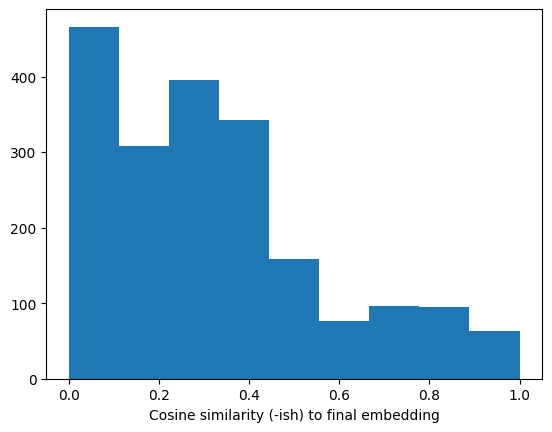

/home/neverix/.cache/pypoetry/virtualenvs/micrlhf-progress-a058ydGG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/neverix/.cache/pypoetry/virtualenvs/micrlhf-progress-a058ydGG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


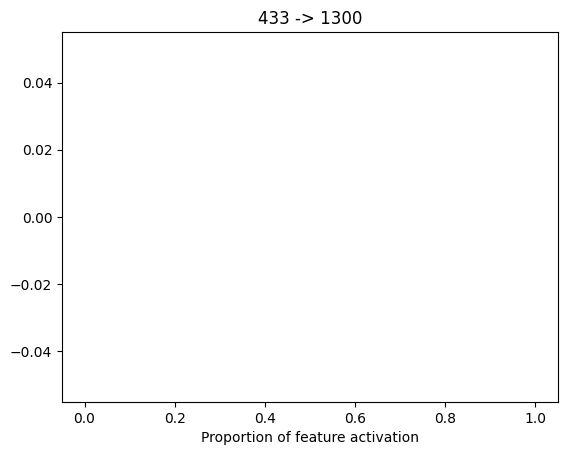

In [8]:
from matplotlib import pyplot as plt
import jax.numpy as jnp

def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

# task_name = "antonyms"
# layer = 11
# source_resid_feature = 5971
# attn_out_feature = 4080
task_name = "location_language"
layer = 13
source_resid_feature = 433
attn_out_feature = 1300

task = tasks[task_name]

print(len(task))

# task = {
#     k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
# }

print(len(task))

pairs = list(task.items())

batch_size = 16
n_shot=5
max_seq_len = 128
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot,
                   max_seq_len=max_seq_len, seed=seed,
                   prompt=prompt, use_same_examples=False)

layers = list(range(layer - 1, layer + 2))
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)

from micrlhf.utils.load_sae import sae_encode, weights_to_resid
from micrlhf.llama import LlamaBlock, LlamaAttention, LlamaInputs


biggest_feature = circuitizer.ie_resid[layer].mean((0, 1)).argmax().tolist()
attn_features = circuitizer.ie_attn[layer].mean((0, 1))
biggest_attn_feature = jnp.argsort(attn_features)[-2]
# source_resid_feature = biggest_feature
# attn_out_feature = biggest_attn_feature
resid_sae = circuitizer.get_sae(layer=layer)
attn_sae = circuitizer.get_sae(layer=layer, label="attn_out")
resid_sae = {k: v.astype(jnp.float32) for k, v in resid_sae.items()}
attn_sae = {k: v.astype(jnp.float32) for k, v in attn_sae.items()}
r_pre = circuitizer.resids_pre[layer]
r_mid = circuitizer.resids_mid[layer]
attn_out = r_mid - r_pre
_, pre_encodings, recon = sae_encode(resid_sae, r_pre.astype(jnp.float32))
pre_encodings = pre_encodings * jnp.zeros(pre_encodings.shape[-1]).at[source_resid_feature].set(1)
err_r = r_pre - recon
_, attn_encodings, _ = sae_encode(attn_sae, attn_out.astype(jnp.float32))
r_other = weights_to_resid(pre_encodings, resid_sae) + err_r
attn_subblock = circuitizer.llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(0).get().delta
attn_layer = attn_subblock.select().at_instances_of(LlamaAttention).pick_nth_selected(0).get()
attn_ln = attn_subblock.select().at_instances_of(pz.nn.RMSLayerNorm).pick_nth_selected(0).get()
r_other_n = pz.nx.wrap(r_other, "batch", "seq", "embedding")
attn_input = attn_ln(r_other_n)
v_n = attn_layer.input_to_value(attn_input)
# v = v_n.unwrap("batch", "seq", "kv_heads", "projection")
qk = circuitizer.qk[layer]
qk_n = pz.nx.wrap(qk, "batch", "kv_heads", "q_rep", "seq", "kv_seq")
out_n = attn_layer.attn_value_to_output((qk_n, v_n))
out = out_n.unwrap("batch", "seq", "embedding")
_, alt_attn_encodings, _ = sae_encode(attn_sae, out.astype(jnp.float32))
# qk_n.named_shape
# out_raw = jnp.einsum("bokp,bkqso->bskqp", v, qk)
# out_n = pz.nx.wrap(out_raw, "batch", "seq", "kv_heads", "q_rep", "projection")
# out = attn_layer.attn_value_to_output(out_n)
proportions = (alt_attn_encodings * attn_encodings).sum(-1) / (jnp.linalg.norm(attn_encodings, axis=-1) ** 2)
plt.hist(proportions.flatten().tolist(), bins = jnp.linspace(0, 1, 10))
plt.xlabel("Cosine similarity (-ish) to final embedding")
plt.show()
proportions_feature = jax.nn.relu(jnp.minimum(alt_attn_encodings[..., attn_out_feature] / attn_encodings[..., attn_out_feature], 1))
plt.title(f"{source_resid_feature} -> {attn_out_feature}")
plt.hist(proportions_feature.flatten().tolist(), bins = jnp.linspace(0, 1, 10))
plt.xlabel("Proportion of feature activation")
plt.show()